In [1]:
import pickle
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import seaborn as sns
import matplotlib.pyplot as plt
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [3]:
# Exclude NSC predictors
nsc_predictors = ['pre_num_nsc_coll', 'num_nsc_coll', 'pre_nsc_terms', 'nsc_terms', 
                  'enrolled_nsc','admrate','gradrate','satvr25','satvr75','satmt25', 'satmt75','satwr25','satwr75',
                  'nsc_coll_type_1', 'nsc_coll_type_2', 'nsc_coll_type_3', 'nsc_coll_type_4',
                  'nsc_coll_type_5','nsc_coll_type_6','nsc_coll_type_7', 'nsc_coll_type_8'] + \
                 [e1+e2+str(e3) for e1 in ['enrolled_nsc_', 'enrl_intensity_nsc_'] for e2 in ['fa','su','sp'] for e3 in range(1,7)]
predictors = np.setdiff1d(list(df.columns.values)[10:], nsc_predictors)
print(len(predictors))

274


In [4]:
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

In [5]:
# Exclude NSC enrollees
train_df = df[np.array(df.valid == 0) & np.array(df.enrolled_nsc == 0)]
test_df = df[np.array(df.valid == 1) & np.array(df.enrolled_nsc == 0)]
print(train_df.shape,test_df.shape)

(281317, 341) (31200, 341)


In [6]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test               

In [7]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [8]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = KFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [9]:
five_folds = create_cv_folds(train_df)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [10]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [11]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(8,21):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto")
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(8,21),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Max_depth = 8
Mean CV AUC: 0.8629

Max_depth = 9
Mean CV AUC: 0.8668

Max_depth = 10
Mean CV AUC: 0.8698

Max_depth = 11
Mean CV AUC: 0.8729

Max_depth = 12
Mean CV AUC: 0.8751

Max_depth = 13
Mean CV AUC: 0.8769

Max_depth = 14
Mean CV AUC: 0.8787

Max_depth = 15
Mean CV AUC: 0.8802

Max_depth = 16
Mean CV AUC: 0.8814

Max_depth = 17
Mean CV AUC: 0.8823



KeyboardInterrupt: 

In [12]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=16,
                                random_state=0, n_jobs=20, max_features="auto")
    auc = cross_validation_RF(rf, five_folds)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

Number of Trees = 100
Mean CV AUC: 0.8809

Number of Trees = 120
Mean CV AUC: 0.8809



KeyboardInterrupt: 

In [13]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(5,max_nf+1):
    rf = RandomForestClassifier(n_estimators=100, criterion="entropy", 
                                max_depth=16,
                                random_state=0, n_jobs=20, max_features=nf)
    auc = cross_validation_RF(rf, five_folds)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(5,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

Max_features = 5
Mean CV AUC: 0.8687

Max_features = 6
Mean CV AUC: 0.8722

Max_features = 7
Mean CV AUC: 0.8731

Max_features = 8
Mean CV AUC: 0.8751

Max_features = 9
Mean CV AUC: 0.8761

Max_features = 10
Mean CV AUC: 0.8768

Max_features = 11
Mean CV AUC: 0.8779

Max_features = 12
Mean CV AUC: 0.8784

Max_features = 13
Mean CV AUC: 0.8791

Max_features = 14
Mean CV AUC: 0.8799

Max_features = 15
Mean CV AUC: 0.8803

Max_features = 16
Mean CV AUC: 0.8809

Max_features = 17
Mean CV AUC: 0.8811

Max_features = 18
Mean CV AUC: 0.8813

Max_features = 19
Mean CV AUC: 0.8817

Max_features = 20
Mean CV AUC: 0.8819

Max_features = 21
Mean CV AUC: 0.8821

Max_features = 22
Mean CV AUC: 0.8826

Max_features = 23
Mean CV AUC: 0.8827

Max_features = 24
Mean CV AUC: 0.8829

Max_features = 25
Mean CV AUC: 0.883

Max_features = 26
Mean CV AUC: 0.8835

Max_features = 27
Mean CV AUC: 0.8835

Max_features = 28
Mean CV AUC: 0.8835

Max_features = 29
Mean CV AUC: 0.8836

Max_features = 30
Mean CV AUC: 

KeyboardInterrupt: 

In [14]:
rf = RandomForestClassifier(n_estimators=100, criterion="entropy",
                            max_depth=16,
                            random_state=0, n_jobs=20, max_features=11)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=20,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
print("Random Forest:")
print("AUC = {}".format(round(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),4)))
y_test_pred_rf = rf.predict_proba(X_test)[:,1]

Random Forest:
AUC = 0.8826


In [16]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_new_3\\"

In [17]:
# pickle.dump(rf, open(results_dir + "rf.p", "wb"))
pickle.dump(list(y_test_pred_rf), open(results_dir + "y_test_pred_rf.p", "wb"))

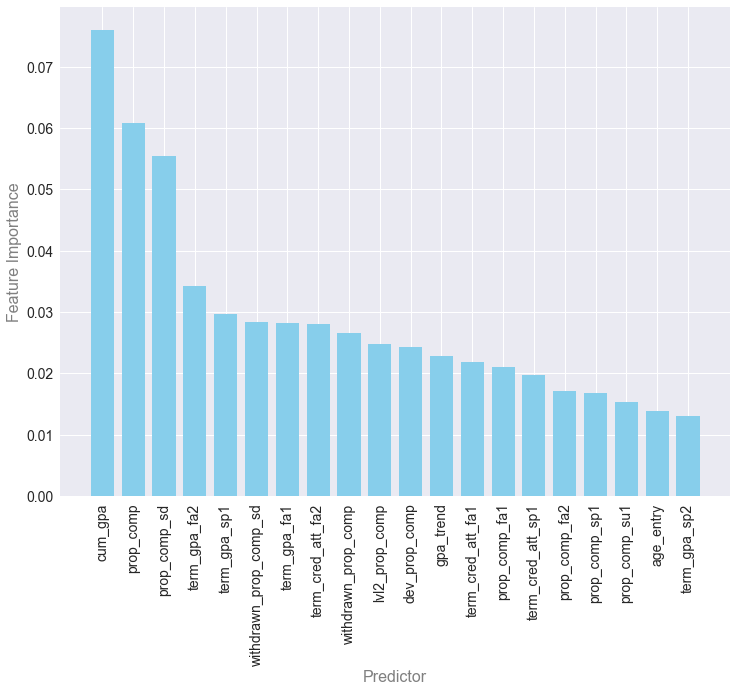

In [18]:
xx = np.array(predictors)[np.argsort(rf.feature_importances_)[::-1]][:20]
yy = rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1]][:20]
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)),yy, width=0.75, color = "skyblue")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16,color="gray")
plt.ylabel("Feature Importance", fontsize=16,color="gray")
plt.savefig(results_dir + "RF_variable_importance.png", bbox_inches="tight")
plt.show()

In [20]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, model):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        model.fit(X_1,y_1)
        if type(model) != sklearn.linear_model.base.LinearRegression:
            p,r,t = precision_recall_curve(y_2, model.predict_proba(X_2)[:,1])
            auc = roc_auc_score(y_2, model.predict_proba(X_2)[:,1])
        else:
            p,r,t = precision_recall_curve(y_2, model.predict(X_2))
            auc = roc_auc_score(y_2, model.predict(X_2))
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [21]:
best_threshold = cross_validation(train_df, rf)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\

0.8779430251236242 0.0023684803175949313


In [22]:
best_threshold

0.3754865496057453

In [23]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [24]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_rf = create_confusion_matrix(y_test_pred_rf, best_threshold, "RF_cm1")

F1 threshold = 0.375:

         Pred_0   Pred_1         
Real_0  17564.0   3338.0  20902.0
Real_1   2337.0   7961.0  10298.0
        19901.0  11299.0  31200.0

F1 score = 0.7372


In [25]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred_rf)[:num_of_0]] = 0
alternative_threshold = y_test_pred_rf[np.argsort(y_test_pred_rf)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_rf = create_confusion_matrix(y_test_pred_binary, best_threshold, "RF_cm2")

Alternative threshold = 0.414:

         Pred_0   Pred_1         
Real_0  18136.0   2766.0  20902.0
Real_1   2756.0   7542.0  10298.0
        20892.0  10308.0  31200.0

F1 score = 0.732


In [26]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_rf,(alternative_threshold,)+pr2_rf]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "RF_precision_recall.csv", index=True)